##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core API를 사용하여 숫자 인식을 수행하는 멀티레이어 퍼셉트론

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/core/mlp_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/core/mlp_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 노트북에서는 [TensorFlow Core 하위 수준 API](https://www.tensorflow.org/guide/core)를 사용하여 [멀티레이어 퍼셉트론](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy) 및 [MNIST 데이터세트](http://yann.lecun.com/exdb/mnist)[로 손으로 작성한 숫자를 분류하는 엔드 투 엔드 머신러닝 워크플로를 구축합니다. TensorFlow Core 및 기본 사용 사례에 대한 자세한 내용은 ](http://yann.lecun.com/exdb/mnist)[Core API 개요](https://developers.google.com/machine-learning/crash-course/introduction-to-neural-networks/anatomy)를 방문하여 확인하세요.

## 멀티레이어 퍼셉트론(MLP) 개요

MLP(멀티레이어 퍼셉트론)는 [다중 클래스 분류](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/video-lecture) 문제 접근에 사용하는 일종의 피드포워드 신경망입니다. MLP를 빌드하기 전에 퍼셉트론, 레이어 및 활성화 함수의 개념을 이해하는 것이 중요합니다.

멀티레이어 퍼셉트론은 퍼셉트론이라는 기능 단위로 구성됩니다. 퍼셉트론의 수식은 다음과 같습니다.

$$Z = \vec{w}⋅\mathrm{X} + b$$

여기서,

- $Z$: 퍼셉트론 출력
- $\mathrm{X}$: 특성 행렬
- $\vec{w}$: 가중치 벡터
- $b$: 바이어스

이러한 퍼셉트론이 쌓이면 밀집 레이어라는 구조를 형성하고, 이를 연결하여 신경망을 구축할 수 있습니다. 밀집 레이어의 수식은 퍼셉트론의 수식과 유사하지만 대신 가중치 행렬과 바이어스 벡터를 사용합니다.

$$Y = \mathrm{W}⋅\mathrm{X} + \vec{b}$$

여기서,

- $Z$: 밀집 레이어 출력
- $\mathrm{X}$: 특성 행렬
- $\mathrm{W}$: 가중치 행렬
- $\vec{b}$: 바이어스 벡터

MLP에서는 한 레이어의 출력이 다음 레이어의 입력과 완전히 연결되는 방식으로 여러 개의 밀집 레이어가 연결됩니다. 밀집 레이어의 출력에 비선형 활성화 함수를 추가하면 MLP 분류자가 복잡한 결정 경계를 학습하고 보이지 않는 데이터로 일반화하는 데 도움이 될 수 있습니다.

## 설치하기

시작하려면 TensorFlow, [pandas](https://pandas.pydata.org), [Matplotlib](https://matplotlib.org), [seaborn](https://seaborn.pydata.org)을 가져옵니다.

In [2]:
# Use seaborn for countplot.
!pip install -q seaborn

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 21:41:38.323625: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:41:38.323729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:41:38.323738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


## 데이터 로드하기

이 튜토리얼에서는 [MNIST 데이터세트](http://yann.lecun.com/exdb/mnist)를 사용하고 손으로 작성한 숫자를 분류할 수 있는 MLP 모델을 빌드하는 방법을 보여줍니다. [TensorFlow 데이터세트](https://www.tensorflow.org/datasets/catalog/mnist)의 데이터세트를 사용할 수 있습니다.

MNIST 데이터세트를 훈련, 검증 및 테스트세트로 분할합니다. 훈련한는 동안 검증 세트를 사용하여 모델의 일반화 가능성을 측정할 수 있으므로 테스트세트가 모델 성능에 대해 최종적으로 비편향 추정치 역할을 할 수 있습니다.


In [5]:
train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

MNIST 데이터세트는 손으로 작성한 숫자와 이에 해당하는 실제 레이블로 구성되어 있습니다. 아래에서는 몇 가지 예제를 시각화합니다.

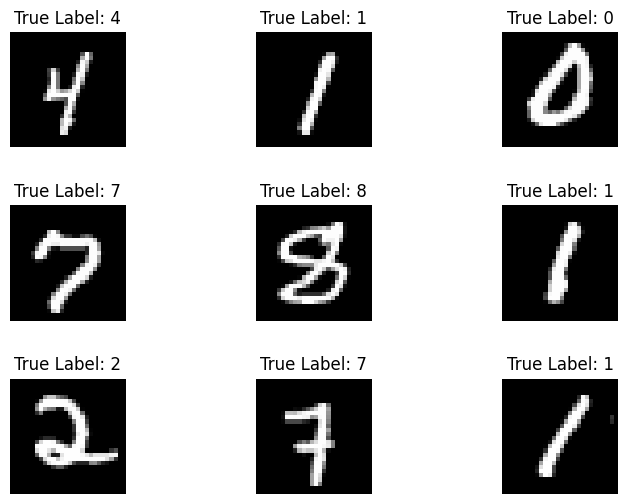

In [6]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)


또한 훈련 데이터에서 숫자 분포를 검토하여 각 클래스가 데이터세트에서 잘 표현되어 있는지 확인합니다.


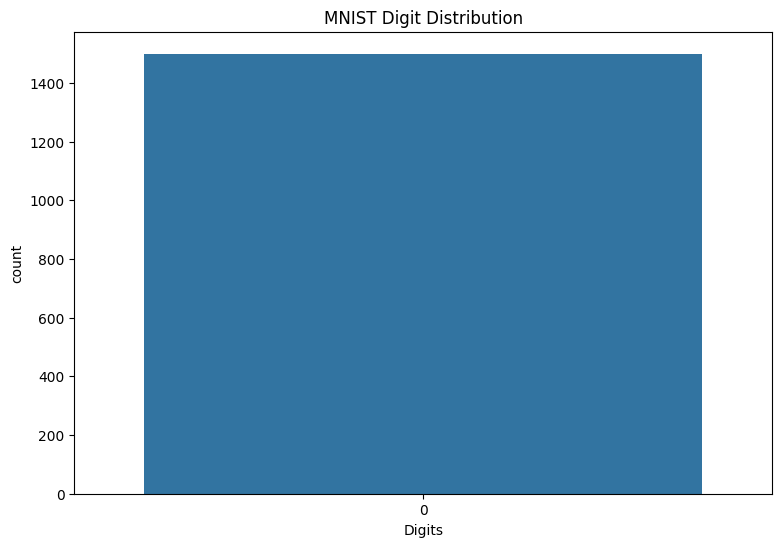

In [7]:
sns.countplot(y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

## 데이터 전처리

먼저 이미지를 플래트닝(flattening)하여 특성 행렬을 2차원으로 변형합니다. 다음으로 [0,255]의 픽셀 값이 [0,1]의 범위에 들어가도록 데이터의 크기를 조정합니다. 이 단계는 입력 픽셀이 유사한 분포를 갖도록 하고 훈련 수렴에 도움이 됩니다.

In [8]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

## MLP 빌드하기

먼저 [ReLU](https://developers.google.com/machine-learning/glossary#ReLU) 및 [Softmax](https://developers.google.com/machine-learning/glossary#softmax) 활성화 함수를 시각화합니다. 두 함수는 각각 `tf.nn.relu` 및 `tf.nn.softmax`에서 사용할 수 있습니다. ReLU는 입력이 양수이면 입력을 출력하고 그렇지 않으면 0을 출력하는 비선형 활성화 함수입니다.

$$\text{ReLU}(X) = max(0, X)$$

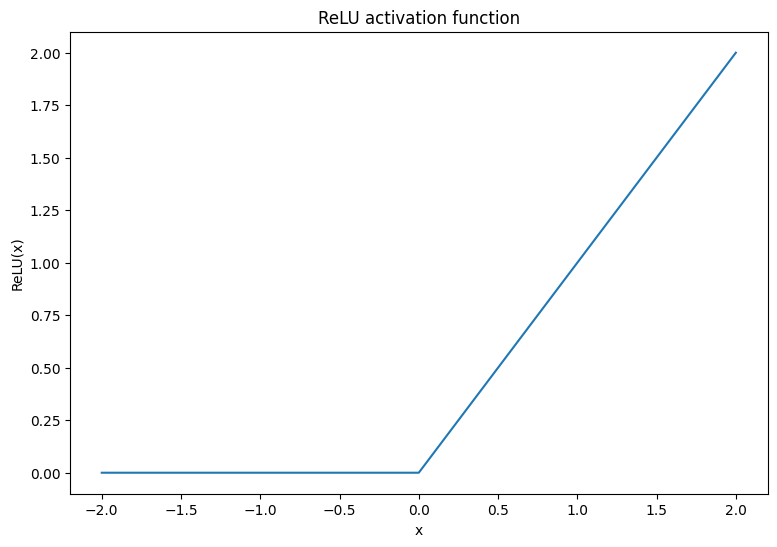

In [9]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x));
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU activation function');

소프트맥스(softmax) 활성화 함수는 $m$ 실수를 $m$ 출력값/클래스가 있는 확률 분포로 변환하는 노멀라이즈 지수 함수입니다. 이것은 신경망의 출력에서 클래스 확률을 예측하는 데 유용합니다.

$$\text{Softmax}(X) = \frac{e^{X}}{\sum_{i=1}^{m}e^{X_i}}$$

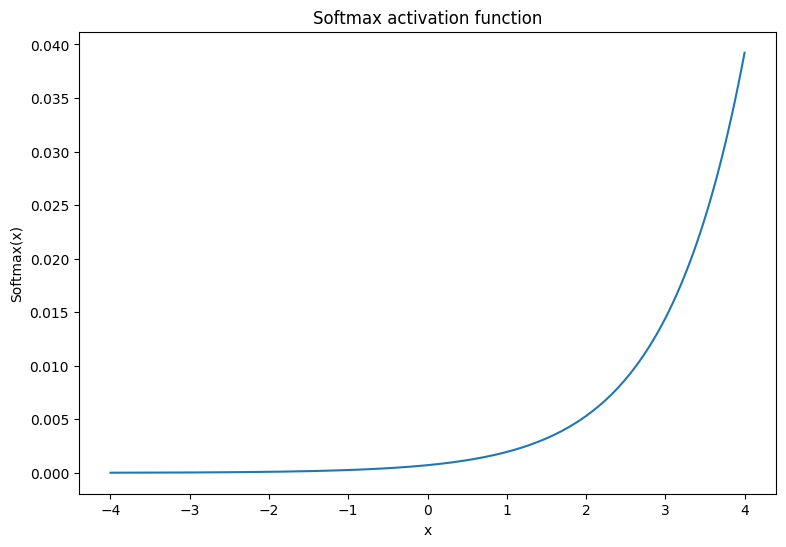

In [10]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0));
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('Softmax activation function');

### 밀집 레이어

밀집 레이어에 대한 클래스를 생성합니다. 정의에 따르면 한 레이어의 출력은 MLP에서 다음 레이어의 입력과 완전히 연결됩니다. 따라서 밀집 레이어의 입력 차원은 이전 레이어의 출력 차원을 기반으로 유추할 수 있으며 초기화를 진행하는 동안 미리 지정할 필요가 없습니다. 활성화 출력이 너무 크거나 작아지는 것을 방지하기 위해 가중치도 적절하게 초기화되어야 합니다. 가장 널리 사용되는 가중치 초기화 방법 중 하나는 가중치 행렬의 각 요소가 다음 방식으로 샘플링되는 Xavier 스키마입니다.

$$W_{ij} \sim \text{Uniform}(-\frac{\sqrt{6}}{\sqrt{n + m}},\frac{\sqrt{6}}{\sqrt{n + m}})$$

바이어스 벡터는 0으로 초기화할 수 있습니다.

In [11]:
def xavier_init(shape):
  # Computes the xavier initialization values for a weight matrix
  in_dim, out_dim = shape
  xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
  weight_vals = tf.random.uniform(shape=(in_dim, out_dim), 
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
  return weight_vals

Xavier 초기화 메서드는 `tf.keras.initializers.GlorotUniform`으로도 구현할 수 있습니다.

In [12]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases using Xavier scheme
      self.w = tf.Variable(xavier_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

다음으로 레이어를 순차적으로 실행하는 MLP 모델용 클래스를 빌드합니다. 모델 변수는 차원 추론으로 인해 밀집 레이어 호출의 첫 번째 시퀀스 이후에만 사용할 수 있음을 기억해야 합니다.

In [13]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  @tf.function
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

다음 아키텍처를 사용하여 MLP 모델을 초기화합니다.

- 순방향 전달: ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)

softmax 활성화 함수는 MLP로 적용할 필요가 없습니다. 손실 및 예측 함수에서 별도로 계산됩니다.

In [14]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.relu),
    DenseLayer(out_dim=output_size)])

### 손실 함수 정의하기

교차 엔트로피 손실 함수는 모델의 확률 예측에 따라 데이터의 음의 로그우도(negative-log-likelihood)를 측정하기 때문에 멀티클래스 분류 문제에 적합합니다. 실제 클래스에 할당된 확률이 높을수록 손실이 낮아집니다. 교차 엔트로피 손실의 수식은 다음과 같습니다.

$$L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{i=j}^{n} {y_j}^{[i]}⋅\log(\hat{{y_j}}^{[i]})$$

여기서,

- $\underset{n\times m}{\hat{y}}$: 예측 클래스 분포의 행렬
- $\underset{n\times m}{y}$: 실제 클래스의 원-핫 인코딩된 행렬

`tf.nn.sparse_softmax_cross_entropy_with_logits` 함수를 사용하여 교차 엔트로피 손실을 계산할 수 있습니다. 이 함수는 소프트맥스 활성화 함수를 적용하기 위해 모델의 마지막 레이어를 필요로 하지 않으며 클래스 레이블을 원-핫 인코딩할 필요도 없습니다.

In [15]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

훈련을 진행하는 동안 올바른 분류의 비율을 계산하는 기본 정확성 함수를 작성해야 합니다. 소프트맥스 출력으로부터 클래스 예측을 생성하려면 가장 큰 클래스 확률에 해당하는 인덱스를 반환해야 합니다. 

In [16]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### 모델 훈련하기

옵티마이저를 사용하면 표준 경사 하강에 비해 훨씬 더 빠른 수렴 결과를 얻을 수 있습니다. Adam 옵티마이저는 아래에 구현되어 있습니다. TensorFlow Core로 사용자 정의 옵티마이저 프로그램을 설계하는 방법에 대한 자세한 내용은 [옵티마이저](https://www.tensorflow.org/guide/core/optimizers_core) 가이드를 방문하여 확인하세요.

In [17]:
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False
      
    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

이제 미니 배치 경사하강으로 MLP 매개변수를 업데이트하는 사용자 정의 훈련 루프를 작성합니다. 훈련에 미니 배치를 사용하면 메모리 효율성이 높아지고 수렴이 더 빨리 수행됩니다.

In [18]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [19]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

배치 크기가 128인 10개 epoch에 대한 MLP 모델 훈련을 진행합니다. GPU 혹은 TPU와 같은 하드웨어 가속기는 훈련 시간을 단축하는 데 도움이 될 수 있습니다. 

In [20]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data, 
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.223, Training accuracy: 0.934
Validation loss: 0.121, Validation accuracy: 0.962


Epoch: 1
Training loss: 0.080, Training accuracy: 0.975
Validation loss: 0.097, Validation accuracy: 0.971


Epoch: 2
Training loss: 0.047, Training accuracy: 0.986
Validation loss: 0.085, Validation accuracy: 0.977


Epoch: 3
Training loss: 0.033, Training accuracy: 0.990
Validation loss: 0.111, Validation accuracy: 0.971


Epoch: 4
Training loss: 0.027, Training accuracy: 0.991
Validation loss: 0.095, Validation accuracy: 0.976


Epoch: 5
Training loss: 0.022, Training accuracy: 0.992
Validation loss: 0.099, Validation accuracy: 0.976


Epoch: 6
Training loss: 0.017, Training accuracy: 0.994
Validation loss: 0.108, Validation accuracy: 0.975


Epoch: 7
Training loss: 0.018, Training accuracy: 0.994
Validation loss: 0.104, Validation accuracy: 0.976


Epoch: 8
Training loss: 0.016, Training accuracy: 0.995
Validation loss: 0.104, Validation accuracy: 0.979


Epoch: 9
Training loss: 0.014, Training accuracy: 0.995
Validation loss: 0.116, Validation accuracy: 0.976


### 성능 평가

먼저 훈련하는 동안 모델의 손실과 정확성을 시각화하는 플로팅 함수를 작성합니다. 

In [21]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

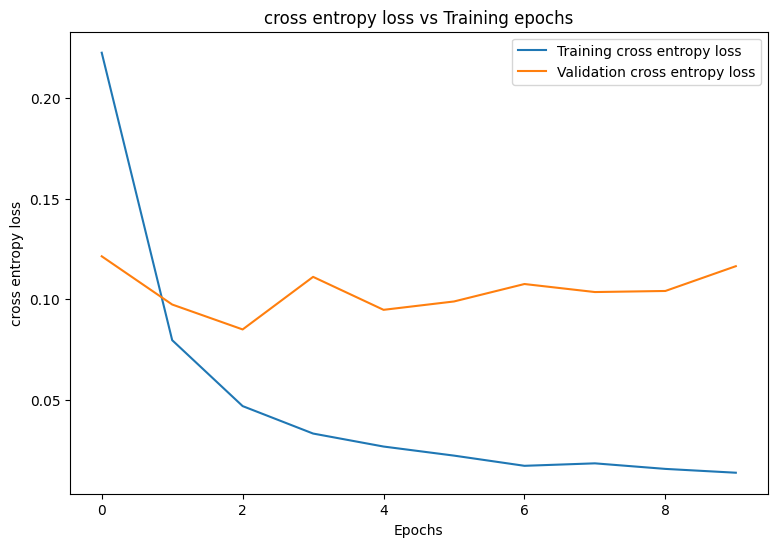

In [22]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

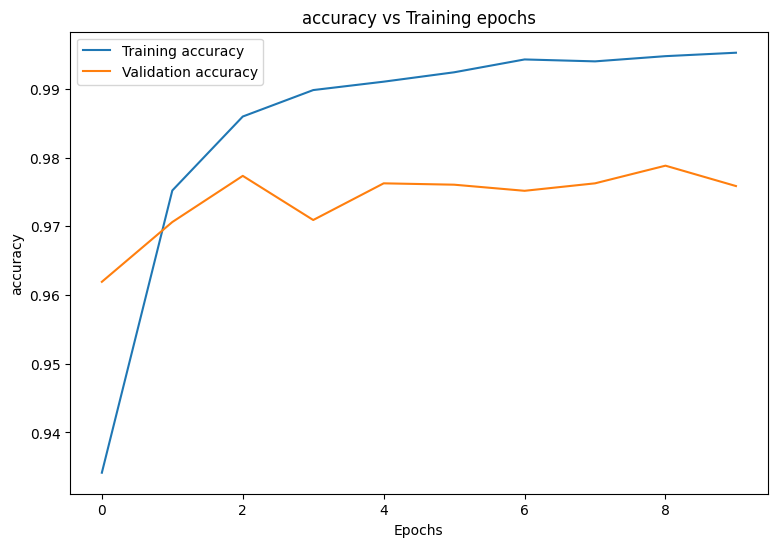

In [23]:
plot_metrics(train_accs, val_accs, "accuracy")

## 모델 저장하기 및 로드하기

먼저 원시 데이터를 선택하고 다음 연산을 수행하는 내보내기 모듈을 만들어 봅니다.

- 데이터 전처리
- 확률 예측
- 클래스 예측

In [24]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y 

In [25]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

이제 이 내보내기 모듈을 `tf.saved_model.save` 함수를 사용하여 저장할 수 있습니다. 

In [26]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [27]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvr4_33_7/mlp_model_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvr4_33_7/mlp_model_export/assets


`tf.saved_model.load`를 사용하여 저장한 모델을 로드하고 보이지 않는 테스트 데이터에서 성능을 점검합니다.

In [28]:
mlp_loaded = tf.saved_model.load(save_path)

In [29]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.977


이 모델은 훈련 데이터세트에서 손으로 작성한 숫자를 분류하는 훌륭한 작업을 수행하고 또한 보이지 않는 데이터로 잘 일반화합니다. 이제 각 숫자에 대한 우수한 성능을 보장하기 위해 모델의 클래스별 정확성을 점검합니다. 

In [30]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  label_filled = tf.cast(tf.fill(pred_label.shape[0], label), tf.int64)
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, label_filled).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.955
Digit 4: 0.958
Digit 8: 0.962
Digit 6: 0.970
Digit 5: 0.980
Digit 9: 0.983
Digit 3: 0.984
Digit 2: 0.988
Digit 0: 0.993
Digit 1: 0.996


이 모델은 많은 멀티클래스 분류 문제에서 흔히 볼 수 있는 것보다 일부 숫자에서 약간 더 많은 어려움을 겪고 있는 것처럼 보입니다. 마지막 연습으로 더 많은 클래스 수준의 인사이트를 수집하기 위해 모델 예측과 해당 실제 레이블의 혼동 행렬을 플로팅합니다. Sklearn과 seaborn에는 혼동 행렬을 생성하고 시각화하는 기능이 있습니다. 

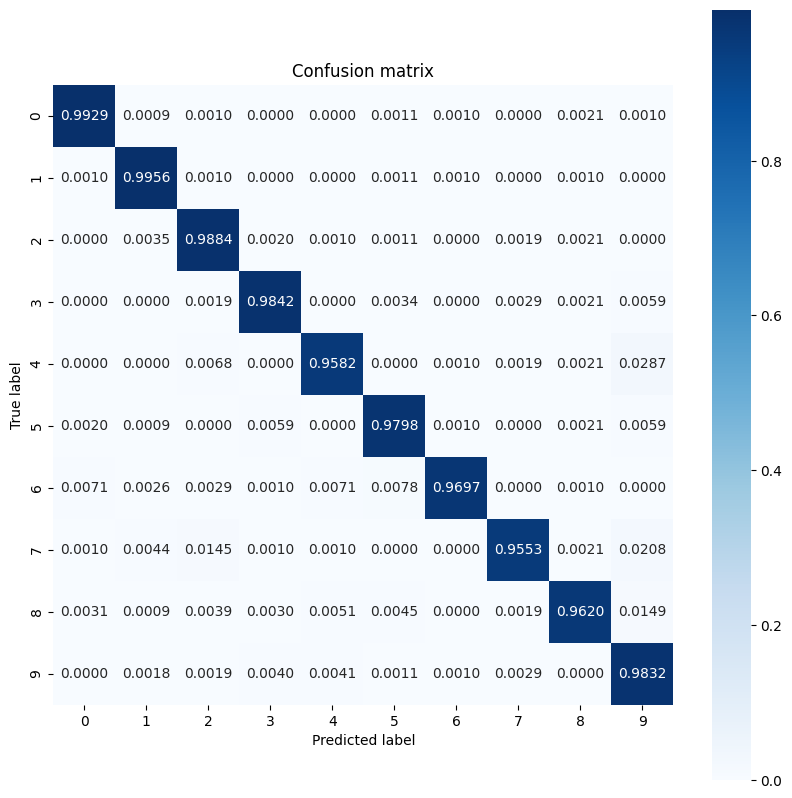

In [31]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(), 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

클래스 수준의 인사이트는 잘못된 분류의 이유를 식별하고 향후 훈련 주기에서 모델 성능을 개선하는 데 도움을 제공할 수 있습니다.

## 결론

이 노트북에서는 [MLP](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax)를 사용하여 멀티클래스 분류 문제를 처리하는 몇 가지 기술을 소개했습니다. 다음은 도움이 될 수 있는 몇 가지 추가 팁입니다.

- 구성 가능성이 높은 머신러닝 워크플로를 구축하는 데 [TensorFlow Core API](https://www.tensorflow.org/guide/core)를 사용할 수 있습니다.
- 초기화 스키마는 훈련하는 동안 모델 매개변수가 사라지거나 폭발하는 사고를 방지하는 데 도움이 될 수 있습니다.
- 과대적합은 신경망의 또 다른 일반적인 문제이지만 이 튜토리얼에서는 문제가 되지 않았습니다. 이에 대한 추가적인 도움이 필요하면 [과대적합 및 과소적합](overfit_and_underfit.ipynb) 튜토리얼을 참조하세요.

TensorFlow Core API를 사용하는 더 많은 예제는 [가이드](https://www.tensorflow.org/guide/core)를 확인하세요. 데이터 로드 및 준비에 대해 자세히 알아보려면 [이미지 데이터 로드](https://www.tensorflow.org/tutorials/load_data/images) 또는 [CSV 데이터 로드](https://www.tensorflow.org/tutorials/load_data/csv) 튜토리얼을 참고하세요.